In [ ]:
#####################
#Copyright@#
'''
A Dual Stage Convolutional Neural Network Architecture for COVID 19 and Pneumonia Detection from Chest CT Scan Images
Reference : "doi....."

Farhan Sadik          E-mail:farhansadikayon@gmail.com
Ankan Ghosh Dastider  E-mail:ankanghoshdastider@gmail.com 
Mohseu Rashid Subah   E-mail:mohseurashid@gmail.com
'''
####################

# **Semantic Segmentation: Implementing SkiCU-Net for Medical Image segmentation**

Importing Libraries


In [ ]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
#from google.colab.patches import cv2_imread
import PIL
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

**Rooting Dataset from Drive**

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')
#Downloading the data , annotations_prepped_train contains mask 

dir_data = "/content/drive/My Drive/Final_Segmentation_Test/"

#dir_img= "/content/drive/My Drive/Final_Dataset/"
#!/usr/bin/env python


  

#dir_img= "/content/drive/My Drive/Final_Dataset/Dataset_all"

dir_seg = dir_data + "/Final_annotation_test/"
dir_img = dir_data + "/Final_Segmentation_test/"

# **Data Analysis**

---



---



*The annotation consists of two class. The lung mask and the background. More than one class can be considered setting n_classes=4*

In [ ]:

#Below code is for visualizing a single segmented image


import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## seaborn has white grid by default so I will get rid of this.
sns.set_style("whitegrid", {'axes.grid' : False}) #Graph contains grid sometimes.knock 'em off :p  


ldseg = np.array(os.listdir(dir_seg)) #Python method listdir() returns a list containing the names of the entries in the directory given by path. The list is in arbitrary order. It does not include the special entries '.' and '..' even if they are present in the directory.
## pick the first image file
fnm = ldseg[45]
print(fnm) #print the name of the entries 

## read in the original image and segmentation labels
seg = cv2.imread(dir_seg + fnm) # (360, 480, 3)
print(seg.shape)
#tf.image.convert_image_dtype(seg, dtype=tf.float16, saturate=False)
cv2_imshow(seg)
img_is = cv2.imread(dir_img + fnm) #image  entries name will be same as annotations/label images
print(img_is.shape)
#tf.image.convert_image_dtype(img_is, dtype=tf.float16, saturate=False)
cv2_imshow(img_is)
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape)) 
#Pre-processing
#seg[(seg==0)]=1
#seg[(seg==128)]=1
#seg[(seg==255)]=1

#cv2_imshow(seg)



## Check the number of labels
#mi, ma = np.min(seg), np.max(seg) 
n_classes =  2 
#ma - mi + 1
#print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes)) #Total numbers of labels


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(n_classes):
    ax = fig.add_subplot(2,n_classes,k+1)
    ax.imshow((seg == k)*1.0) 
    ax.set_title("label = {}".format(k))


plt.show()

**Pre-processing & Visualization of the Data**

In [ ]:
##To simplify the problem, I will reshape all the images to the same size: (128,128). Why (128,128)? This is the iamge shape used in VGG and FCN model in this blog uses a network that takes advantage of VGG structure. The FCN model becomes easier to explain when the image shape is (224,224). However, FCN does not requires the image shape to be (224,224).

#Let's visualize how the resizing make the images look like. The images look fine.

import random
def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

input_height , input_width = 128 , 128
output_height , output_width = 128 , 128


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png") # (360, 480, 3)
    #seg[(seg==0)]=0
    #seg[(seg==128)]=1
    #seg[(seg==255)]=1
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

**Loading the dataset for semantic segmentation**

In [ ]:
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1) #cv2.imread() method loads an image from the specified file. If the image cannot be read (because of missing file, improper permissions, unsupported or invalid format) then this method returns an empty matrix.
        #path: A string representing the path of the image to be read.
        #flag: It specifies the way in which image should be read. It’s default value is cv2.IMREAD_COLOR
        #cv2.IMREAD_COLOR: It specifies to load a color image. Any transparency of image will be neglected. It is the default flag. Alternatively, we can pass integer value 1 for this flag.
        #img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1   #Normalization
        #It looks like the purpose of this normalization is to bring the values in range [-1.0,1.0]. As values for a pixel in grayscale are in range [0,255], we needed to divide by 127.5, to bring 255 to 2.0.
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    #img[(img==0)]=0
   #img[(img==128)]=1
    #img[(img==255)]=1
    img = cv2.resize(img, ( width , height ))
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  )) #Each image is separated into 12 images(class)
    return seg_labels

input_height,input_width=128,128
for (root,dirs,files) in os.walk(dir_data):
  for filenames in dirs:
    dir_img =dir_data + filenames

    images = os.listdir(dir_img)  
    images.sort()

    segmentations  = os.listdir(dir_seg)
    segmentations.sort()
    
    X = []
    Y = []
    for im  in images :
      for seg in segmentations:


        X.append( getImageArr(dir_img + im , input_width , input_height )  )
        Y.append( getSegmentationArr( dir_seg + seg , n_classes , output_width , output_height )  )

X, Y = np.array(X) , np.array(Y)
#X=np.array(X)
print(X.shape,Y.shape)
#print(X.shape)

In [ ]:
## Import usual libraries
import tensorflow as tf
#from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 


**Pre-trained weights**

In [ ]:
## location of VGG weights
VGG_Weights_path = "/content/drive/My Drive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

**Skicu-Net Architecture for medical Image Segmentation**

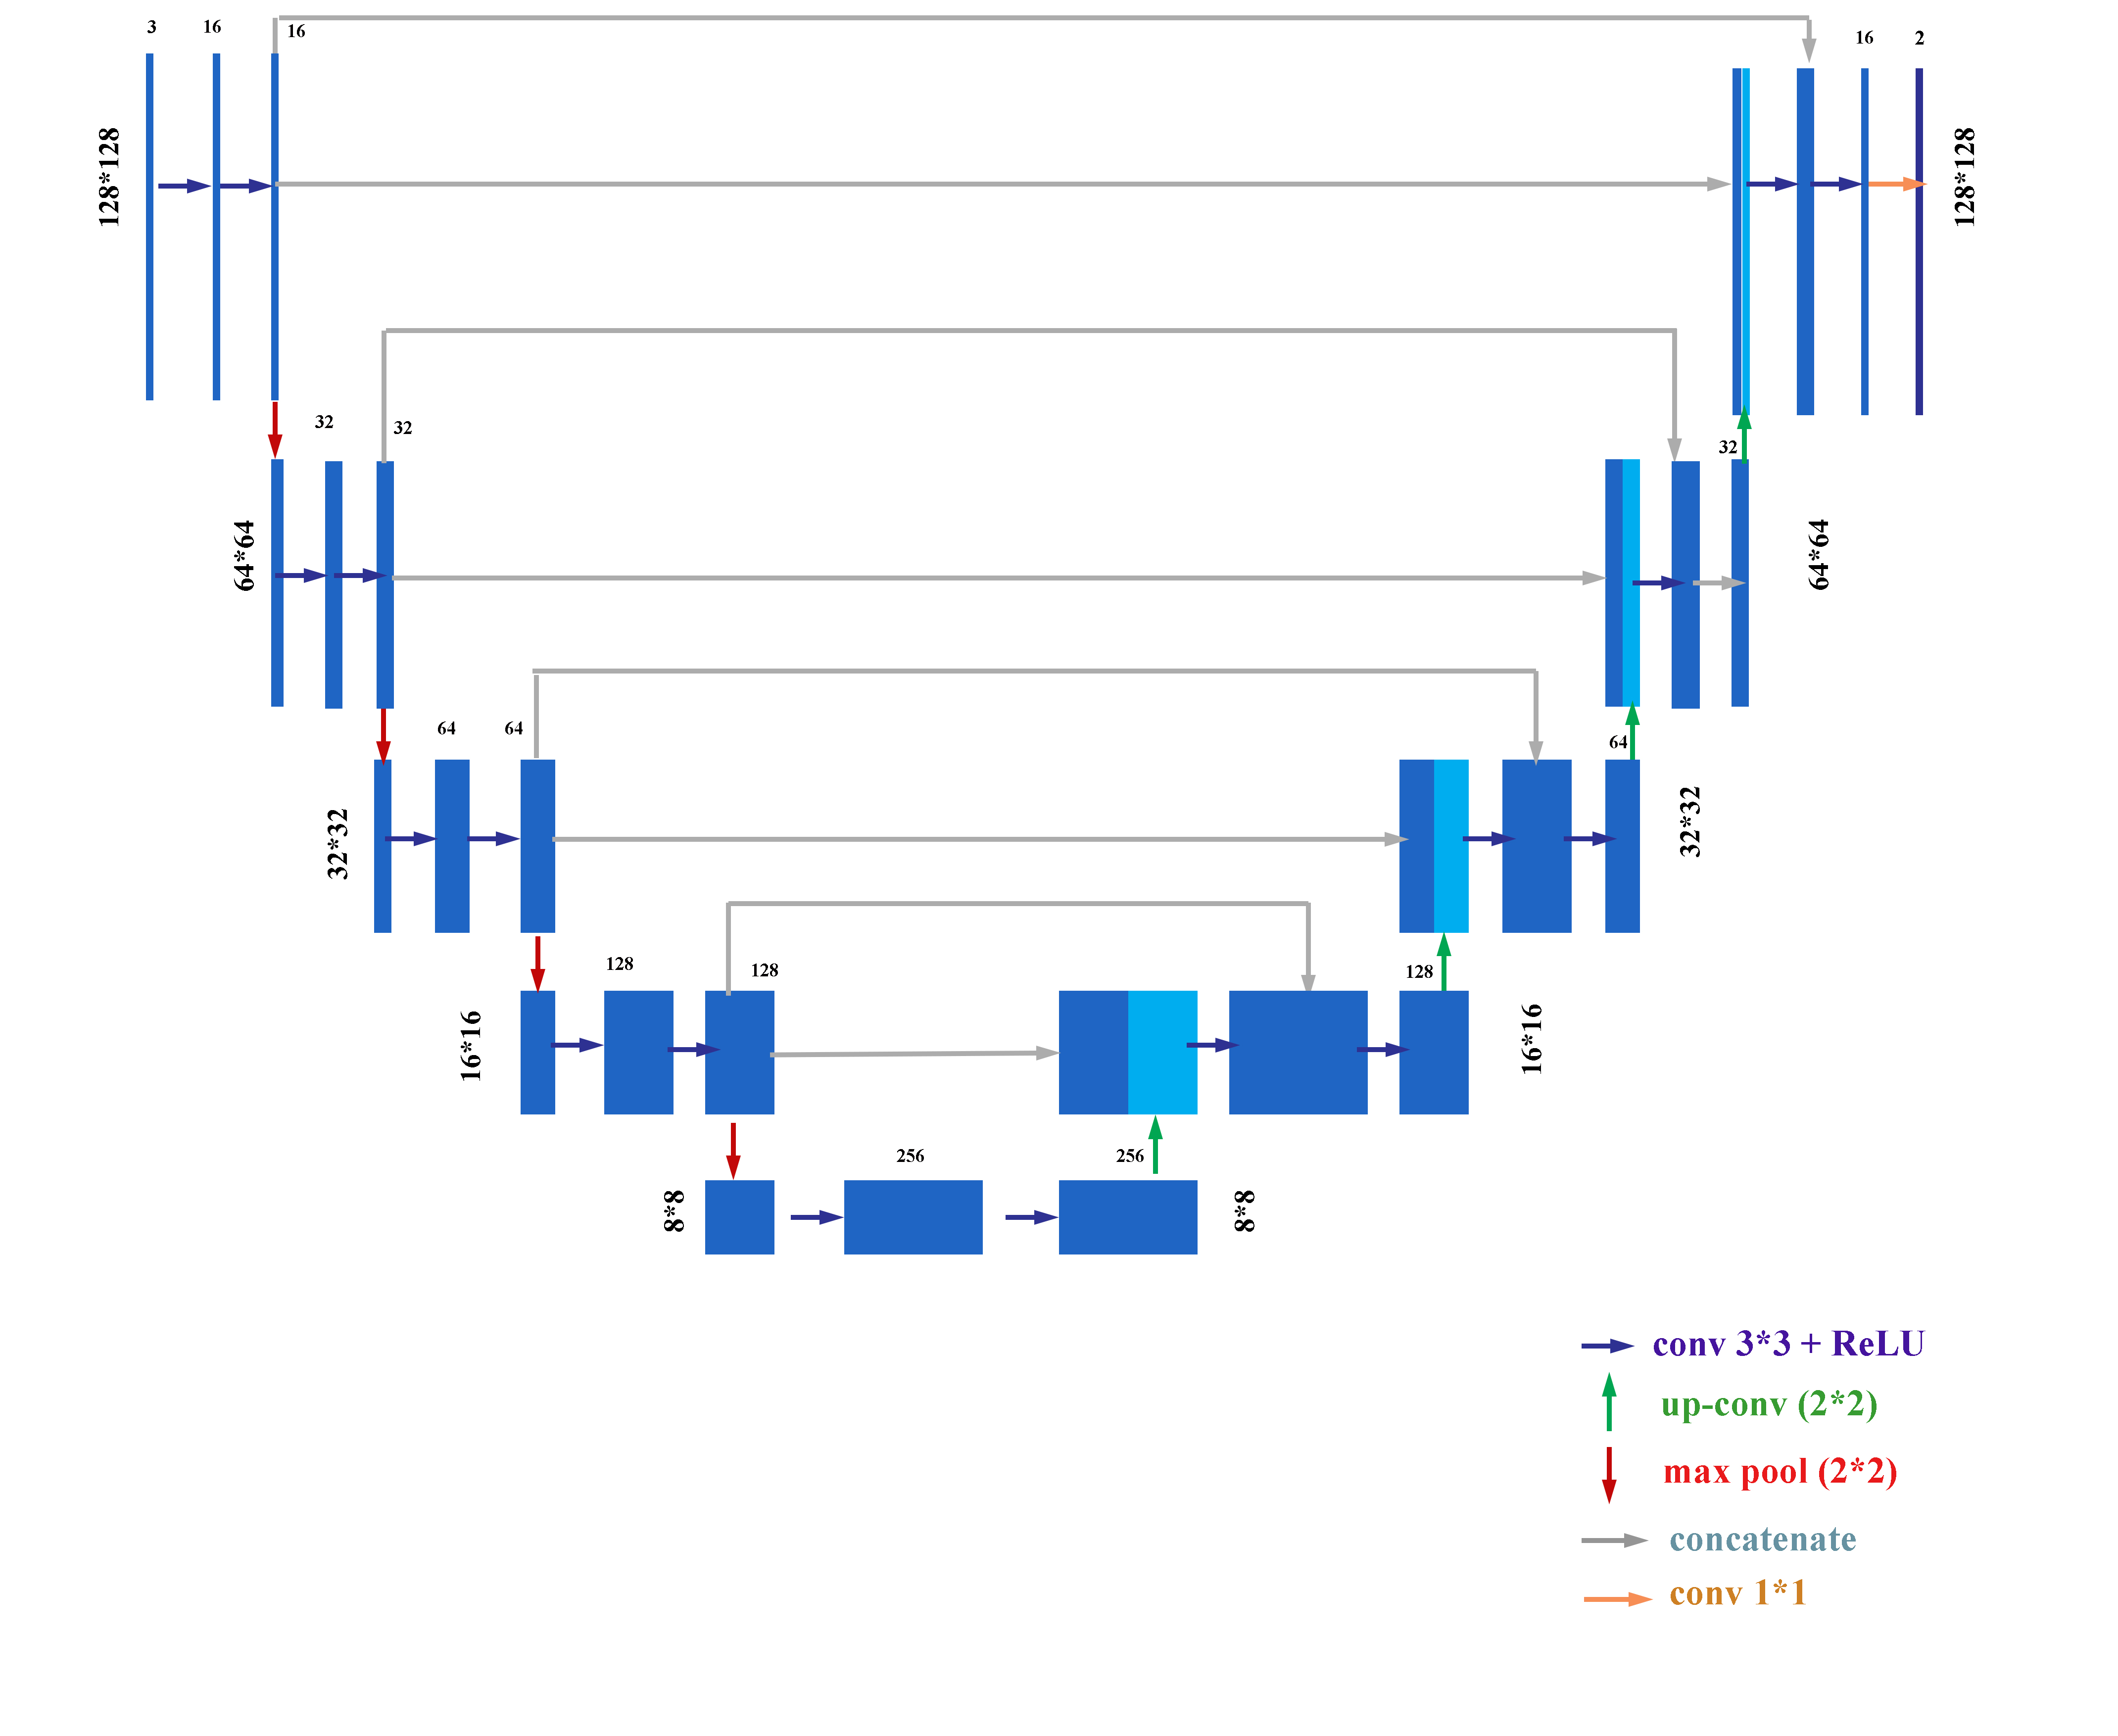

In [ ]:
import tensorflow as tf


IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


#Build the model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = Lambda(lambda x: x / 255)(inputs)
s=inputs

#Contraction path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)
 
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#vgg  = Model(  inputs, c5  )
#vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8

#Expansive path 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6=  concatenate([c6, c4])
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = concatenate([c7, c3])
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8=  concatenate([c8, c2])
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = concatenate([c9, c1], axis=3)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = Conv2D(2, (1, 1), activation='softmax')(c9)
 
model =Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

**Train Test Split**

In [ ]:
from sklearn.utils import shuffle
train_rate = 0.80
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))
                            
X, Y = shuffle(X,Y)
X_train, y_train = X[index_train],Y[index_train]
X_test, y_test = X[index_test],Y[index_test]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#print(y_train)

*#Run the below code to train the model*

In [ ]:
from keras import optimizers


#sgd = optimizers.SGD(lr=1E-6, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

hist1 = model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),batch_size=50,epochs=200,verbose=2)

for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

*Training Evaluation*

In [ ]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

*Validation Result*

In [ ]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

Evaluating Model Parameters: IoU,Pixel Accuracy,F1 Score,Sensitivity,Specificity

In [ ]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    pix_accs=[]
    f1s=[]
    sensis=[]
    specis=[]
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c))
        TN=  np.sum( (Yi != c)&(y_predi != c))
        IoU = TP/float(TP + FP + FN)
        pix_acc=(TP+TN)/float(TP+TN+FP+FN)
        f1= 2*TP/float(FN+FP+2*TP)
        sensi=TP/float(TP+FN)
        speci=TN/float(TN+FP)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f},pix_acc={:4.3f},F1={:4.3f},sensi={:4.3f},speci={:4.3f}".format(c,TP,FP,FN,IoU,pix_acc,f1,sensi,speci))
        IoUs.append(IoU)
        pix_accs.append(pix_acc)
        f1s.append(f1)
        sensis.append(sensi)
        specis.append(specis)

    mIoU = np.mean(IoUs)
    mpix = np.mean(pix_accs)
    mf1 = np.mean(f1s)
    msen = np.mean(sensis)
    mspec = np.mean(specis)
    print("_________________")
    print("Mean IoU: {:4.3f}, Mean pix_acc : {:4.3f},Mean f1: {:4.3f},Mean sensi: {:4.3f},Mean speci: {:4.3f}".format(mIoU,mpix,mf1,msen,mspec))
    
IoU(y_testi,y_predi)

Indiviual Testing

In [ ]:
shape = (224,224)
n_classes= 2

for i in range(10):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()